In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import torch
import json
import plotly.express as px
from transformer_lens import utils
from datasets import load_dataset


import matplotlib.pyplot as plt
import seaborn as sns

from error_eval import *

torch.set_grad_enabled(False)

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
pos = 'all'
layers = list(range(12))
sae_name = 'gpt2_resid'

result_dfs = {}
for i in layers:
    data_path = os.path.join(
        'error_eval_results',
        sae_name,
        f'layer_{i}_pos_{pos}.csv',
    )
    result_dfs[i] = pd.read_csv(data_path)

In [4]:
result_dfs[4]

token  position      loss  substitution_loss  substitution_kl  \
0        50256         0  8.604523           8.611563         0.001794   
1        17402         1  4.787953           4.991229         0.023384   
2        22038         2  3.174028           2.574388         0.094981   
3         4870         3  2.832820           3.350013         0.115174   
4         7806         4  0.000286           0.002920         0.002046   
...        ...       ...       ...                ...              ...   
2031995   3936       122  2.626946           2.761653         0.013941   
2031996    329       123  0.903635           1.012223         0.042977   
2031997    257       124  2.422072           2.810656         0.063245   
2031998   1178       125  1.207361           1.108215         0.027193   
2031999   2745       126  1.547133           1.549773         0.038615   

         norm_corrected_substitution_loss  norm_corrected_substitution_kl  \
0                                8.641123                        0.001052   
1                                4.870447                        0.031064   
2                                2.588204                        0.096537   
3                                3.415127                        0.126341   
4                                0.003096                        0.002206   
...                                   ...                             ...   
2031995                          2.768889                        0.014410   
2031996                          1.027988                        0.040416   
2031997                          2.808385                        0.058674   
2031998                          1.101655                        0.028294   
2031999                          1.586746                        0.040333   

         cos_corrected_substitution_loss  cos_corrected_substitution_kl  \
0                               8.572298                   6.845774e-04   
1                               4.938009                   2.490914e-03   
2                               3.166154                   8.283695e-05   
3                               2.772916                   6.018225e-04   
4                               0.000284                   2.813412e-07   
...                                  ...                            ...   
2031995                         2.639417                   3.829615e-04   
2031996                         0.874306                   1.179026e-03   
2031997                         2.433435                   4.411159e-04   
2031998                         1.217999                   3.637176e-04   
2031999                         1.520233                   2.540089e-04   

         l2_error_preserving_substitution_loss  ...  zero_ablation_loss  \
0                                     8.576875  ...           23.252796   
1                                     4.396870  ...           28.889675   
2                                     2.959094  ...           26.934467   
3                                     3.253842  ...           17.546122   
4                                     0.000970  ...           22.332176   
...                                        ...  ...                 ...   
2031995                               2.480404  ...            9.582205   
2031996                               0.961037  ...           11.698619   
2031997                               2.745543  ...           27.399527   
2031998                               1.330893  ...           25.806316   
2031999                               1.608654  ...           11.523491   

         zero_ablation_kl  mean_ablation_loss  mean_ablation_kl  sae_l0  \
0                6.702333           20.873650          7.529308    11.0   
1                5.925323           17.217062          7.271905    15.0   
2               21.671558           11.382118          8.054785    26.0   
3               18.050423           15.302921         12.897068    32.0   
4               22

<Axes: >

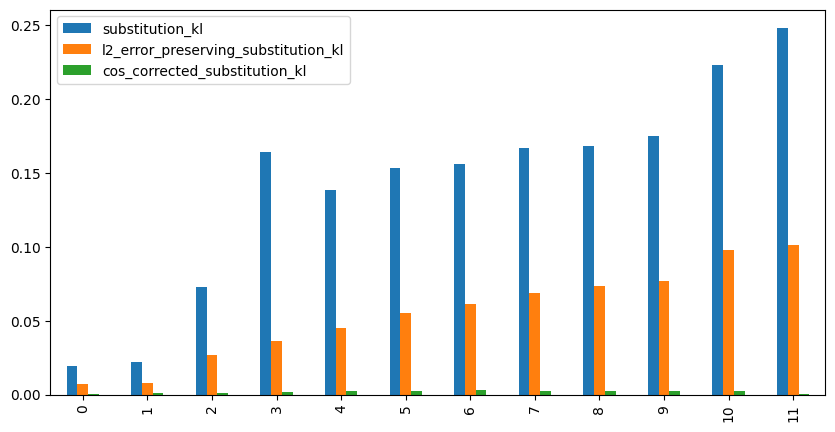

In [5]:
mean_df = pd.DataFrame({
    l: result_dfs[l].mean(axis=0) for l in layers
}).T

kl_cols = ['substitution_kl', 'l2_error_preserving_substitution_kl', 'cos_corrected_substitution_kl']
mean_df[kl_cols].plot(kind='bar', figsize=(10, 5))

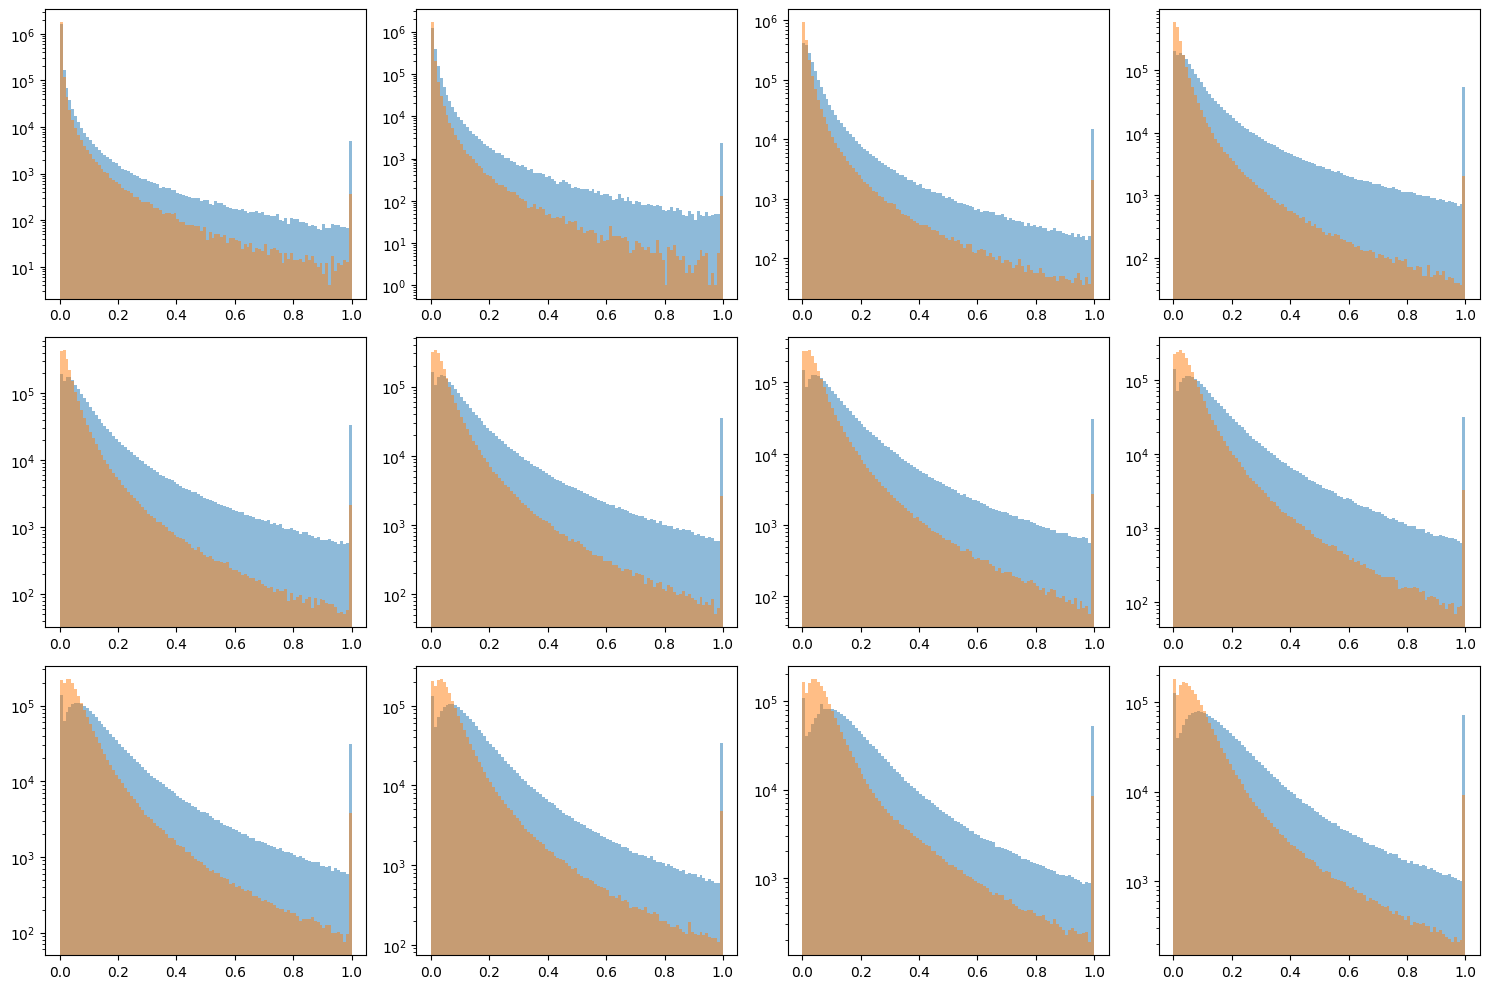

In [6]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

ub = 1
for i in range(12):
    ax = axs[i // 4, i % 4]
    rdf = result_dfs[i]
    ax.hist(np.clip(rdf['substitution_kl'], 0, ub), bins=100, alpha=0.5, label='SAE substitution')
    ax.hist(np.clip(rdf['l2_error_preserving_substitution_kl'], 0, ub), bins=100, alpha=0.5, label='L2 error preserving substitution')
    
    ax.set_yscale('log')

plt.tight_layout()  

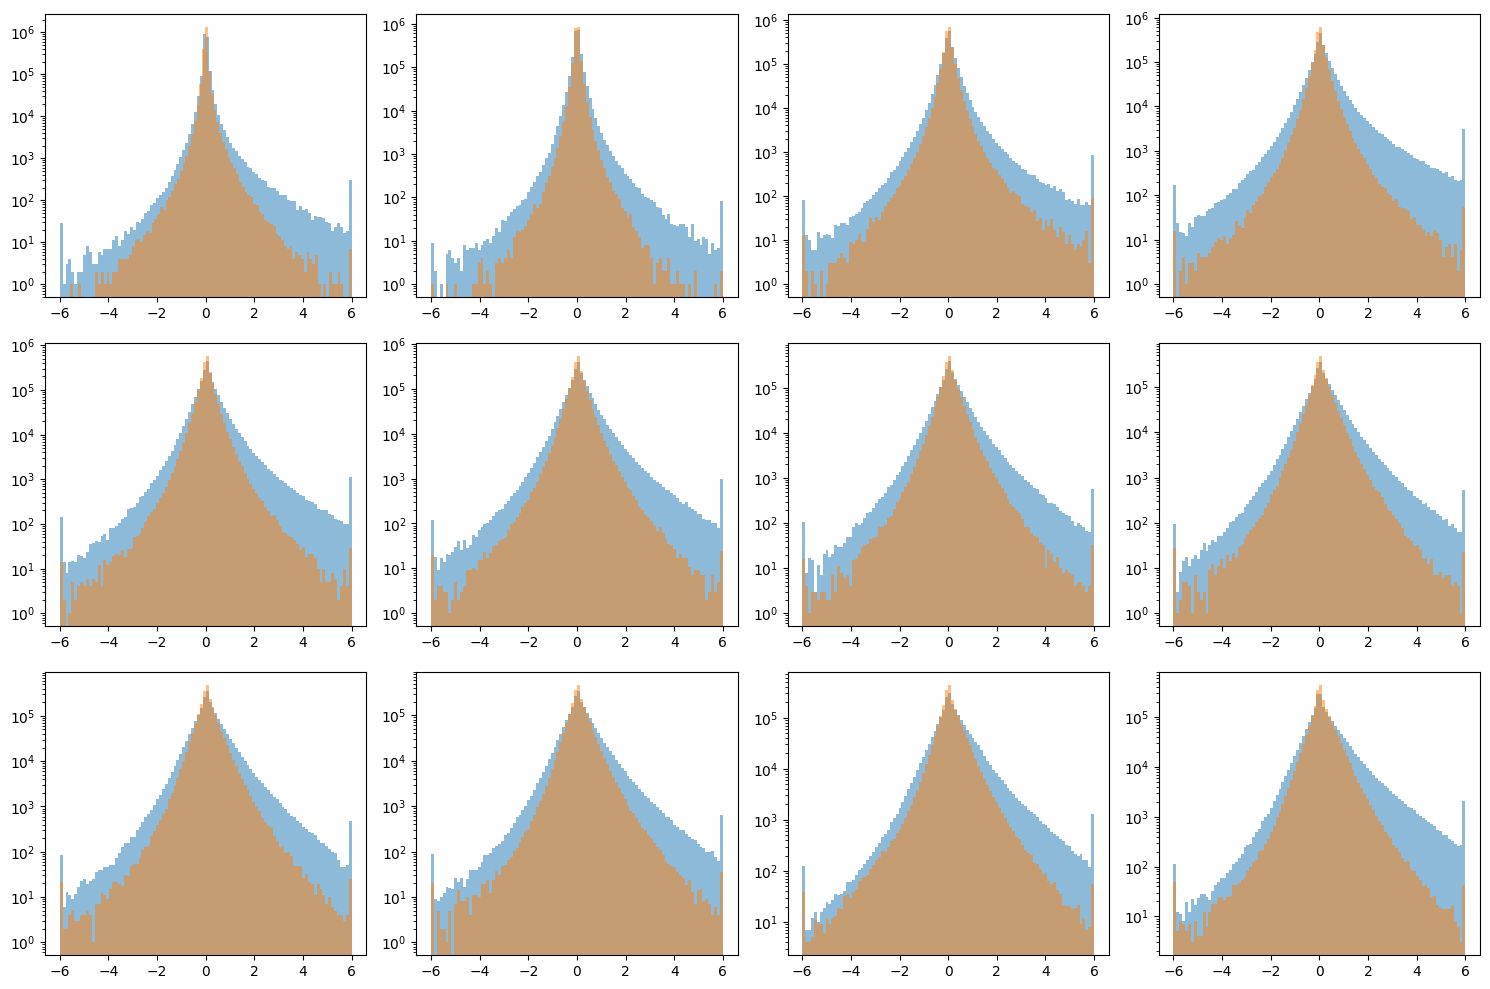

In [7]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

lb, ub = (-6, 6)
for i in range(12):
    ax = axs[i // 4, i % 4]
    rdf = result_dfs[i]
    substitution_loss_change = np.clip(rdf['substitution_loss'] - rdf['loss'], lb, ub)
    random_loss_change = np.clip(rdf['l2_error_preserving_substitution_loss'] - rdf['loss'], lb, ub)
    ax.hist(substitution_loss_change, bins=100, alpha=0.5, label='SAE')
    ax.hist(random_loss_change, bins=100, alpha=0.5, label='L2 error preserving')
    
    ax.set_yscale('log')

plt.tight_layout()  

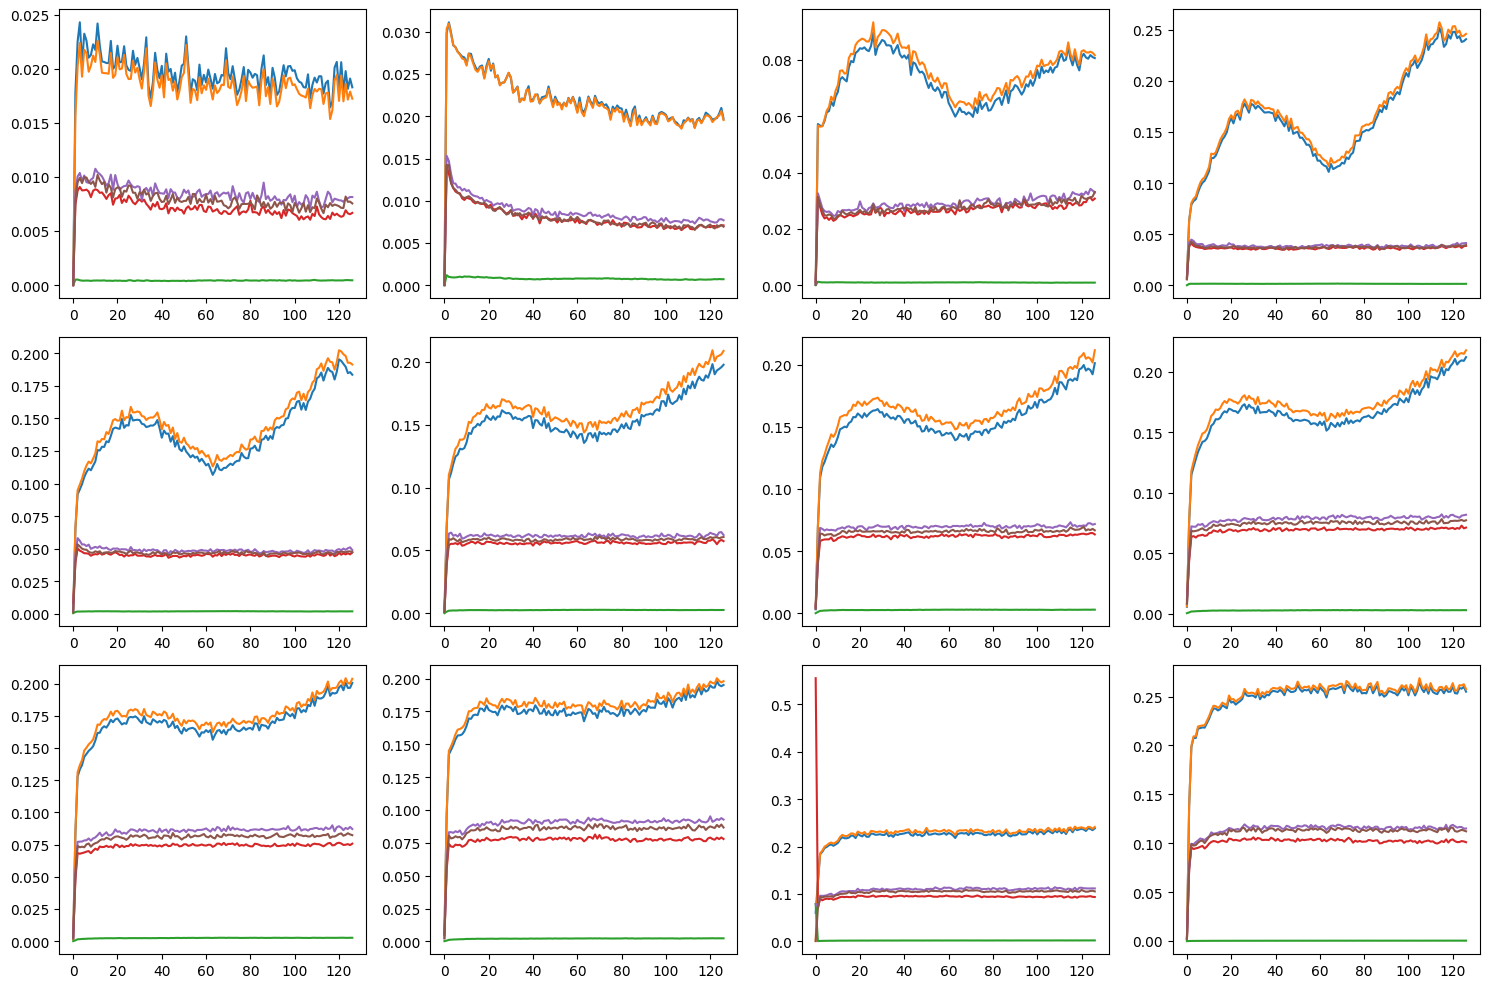

In [8]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

for i in range(12):
    ax = axs[i // 4, i % 4]
    rdf = result_dfs[i]
    kl_by_pos = rdf.groupby('position')[[c for c in rdf.columns if 'kl' in c and 'zero' not in c and 'mean' not in c]].mean()

    ax.plot(kl_by_pos)
    
plt.tight_layout()  

## Single Token Intervention Results

In [9]:
pos = '32'
layers = list(range(12))
sae_name = 'gpt2_resid'

single_token_result_dfs = {}
for i in layers:
    data_path = os.path.join(
        'error_eval_results',
        sae_name,
        f'layer_{i}_pos_{pos}.csv',
    )
    single_token_result_dfs[i] = pd.read_csv(data_path)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

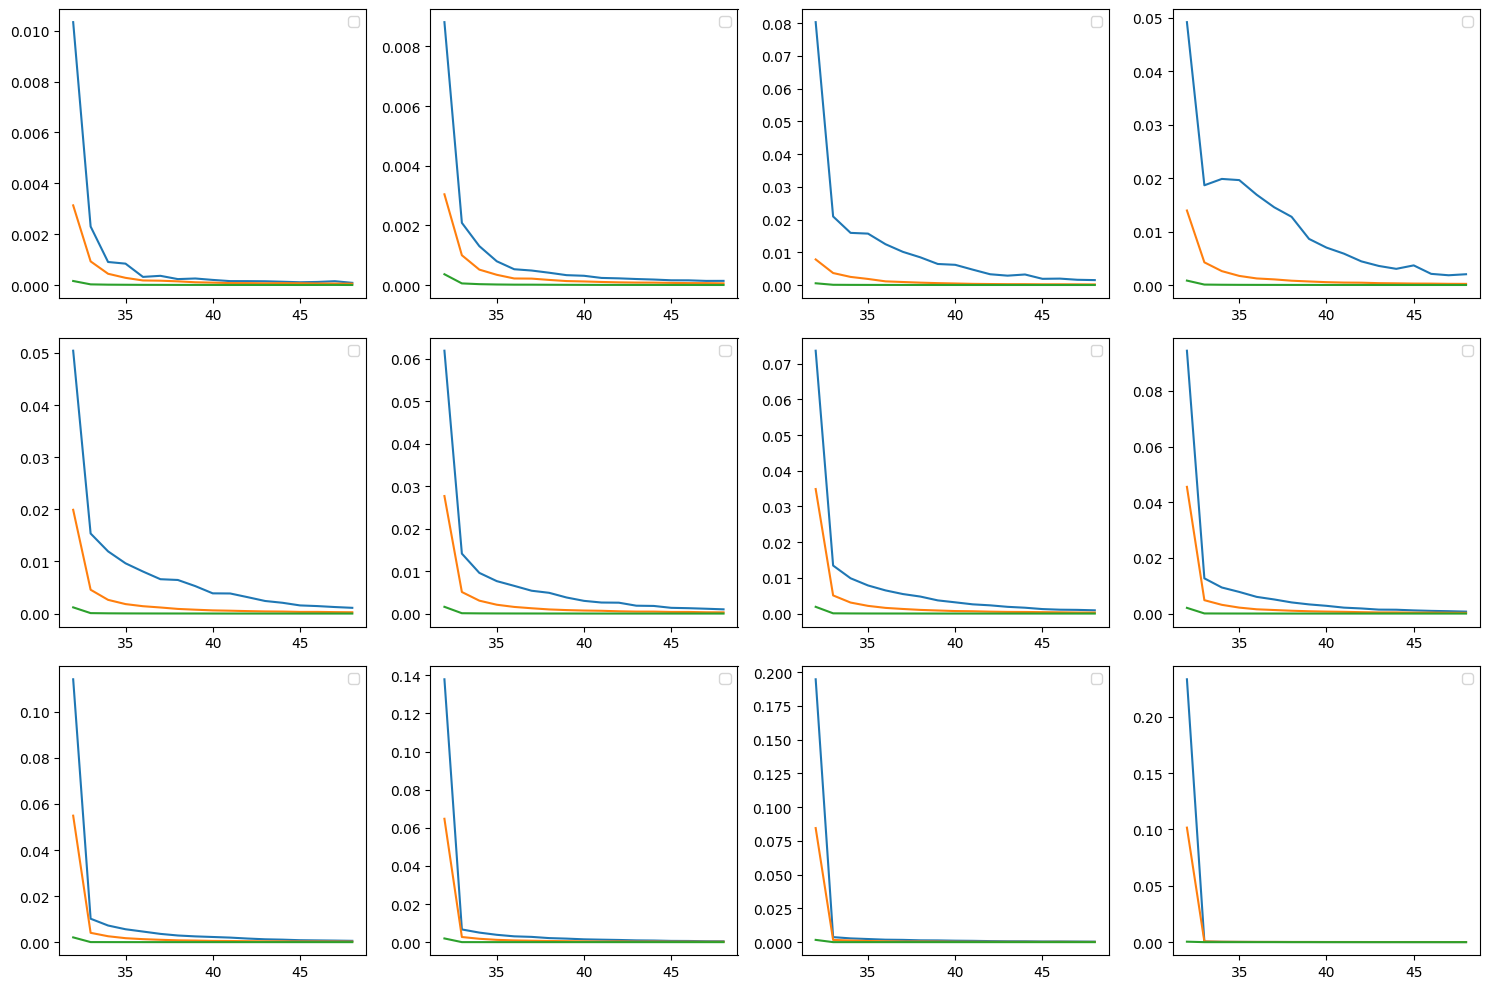

In [10]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i in range(12):
    ax = axs[i // 4, i % 4]
    rdf = single_token_result_dfs[i]
    kl_by_pos = rdf.query('position >= 32 and position <= 48').groupby('position')[kl_cols].mean()

    ax.plot(kl_by_pos)
    ax.legend()
    
plt.tight_layout()  

In [11]:
kl_by_pos

substitution_kl  l2_error_preserving_substitution_kl  \
position                                                         
32               0.233117                             0.101546   
33               0.000532                             0.000616   
34               0.000297                             0.000341   
35               0.000226                             0.000242   
36               0.000165                             0.000186   
37               0.000156                             0.000168   
38               0.000118                             0.000130   
39               0.000117                             0.000128   
40               0.000097                             0.000102   
41               0.000089                             0.000108   
42               0.000088                             0.000094   
43               0.000078                             0.000090   
44               0.000088                             0.000090   
45               0.000068                             0.000096   
46               0.000072                             0.000092   
47               0.000067                             0.000076   
48               0.000076                             0.000077   

          cos_corrected_substitution_kl  
position                                 
32                         3.978729e-04  
33                         1.320025e-09  
34                         2.819225e-09  
35                        -7.537265e-10  
36                         2.273297e-10  
37                         9.195856e-11  
38                        -1.772216e-09  
39                         1.816641e-09  
40                        -6.025088e-10  
41                         1.777409e-09  
42                        -5.529806e-10  
43                         3.777417e-10  
44                        -1.724360e-10  
45                        -2.217455e-09  
46                        -2.622115e-10  
47                         3.708797e-10  
48                         2.326045e-09

In [12]:
single_token_result_dfs[5].head()

token  position      loss  substitution_loss  substitution_kl  \
0  50256         0  8.604523           8.604523              0.0   
1  17402         1  4.787953           4.787953              0.0   
2  22038         2  3.174028           3.174028              0.0   
3   4870         3  2.832820           2.832820              0.0   
4   7806         4  0.000286           0.000286              0.0   

   norm_corrected_substitution_loss  norm_corrected_substitution_kl  \
0                          8.604523                             0.0   
1                          4.787953                             0.0   
2                          3.174028                             0.0   
3                          2.832820                             0.0   
4                          0.000286                             0.0   

   cos_corrected_substitution_loss  cos_corrected_substitution_kl  \
0                         8.604523                            0.0   
1                         4.787953                            0.0   
2                         3.174028                            0.0   
3                         2.832820                            0.0   
4                         0.000286                            0.0   

   l2_error_preserving_substitution_loss  ...  zero_ablation_loss  \
0                               8.604523  ...            8.604523   
1                               4.787953  ...            4.787953   
2                               3.174028  ...            3.174028   
3                               2.832820  ...            2.832820   
4                               0.000286  ...            0.000286   

   zero_ablation_kl  mean_ablation_loss  mean_ablation_kl  sae_l0      sae_l1  \
0               0.0            8.604523               0.0     9.0  2898.96880   
1               0.0            4.787953               0.0    15.0    89.87671   
2               0.0            3.174028               0.0    41.0   135.93878   
3               0.0            2.832820               0.0    42.0   116.46346   
4               0.0            0.000286               0.0    32.0   105.44025   

   reconstruction_error        norm     sae_norm       cos  
0              4.673164  2929.69120  2926.712400  0.999999  
1             13.984047    79.52119    77.109080  0.984529  
2             21.622814    89.75359    91.176100  0.971557  
3             18.996025    85.30570    82.455505  0.974927  
4             16.915197    85.39067    81.447780  0.980548  

[5 rows x 25 columns]

In [13]:
single_token_result_dfs[5].query('position == 5').mean()

token                                           4412.002562
position                                           5.000000
loss                                               4.612622
substitution_loss                                  4.612622
substitution_kl                                    0.000000
norm_corrected_substitution_loss                   4.612622
norm_corrected_substitution_kl                     0.000000
cos_corrected_substitution_loss                    4.612622
cos_corrected_substitution_kl                      0.000000
l2_error_preserving_substitution_loss              4.612622
l2_error_preserving_substitution_kl                0.000000
cos_preserving_substitution_w_sae_norm_loss        4.663866
cos_preserving_substitution_w_sae_norm_kl          0.062193
cos_preserving_substitution_w_true_norm_loss       4.660967
cos_preserving_substitution_w_true_norm_kl         0.058261
zero_ablation_loss                                 4.612622
zero_ablation_kl                        

In [14]:
print(i)

11


In [15]:
i = 5
rdf = single_token_result_dfs[i]
loss_by_pos = rdf.groupby('position')[[c for c in rdf.columns if 'kl' in c and 'zero' not in c and 'mean' not in c]].mean()
px.line(loss_by_pos, title="KL by position").show()

<Axes: >

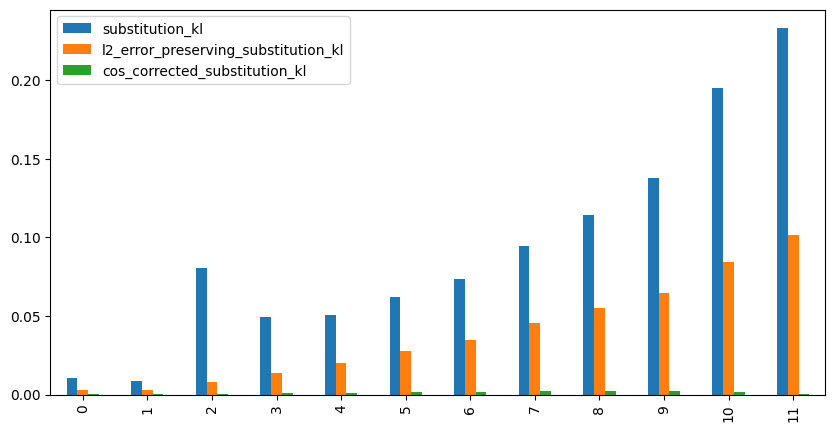

In [16]:
single_token_mean_df = pd.DataFrame({
    l: single_token_result_dfs[l].query('position == 32').mean(axis=0) for l in layers
}).T

kl_cols = ['substitution_kl', 'l2_error_preserving_substitution_kl', 'cos_corrected_substitution_kl']
single_token_mean_df[kl_cols].plot(kind='bar', figsize=(10, 5))

<Axes: >

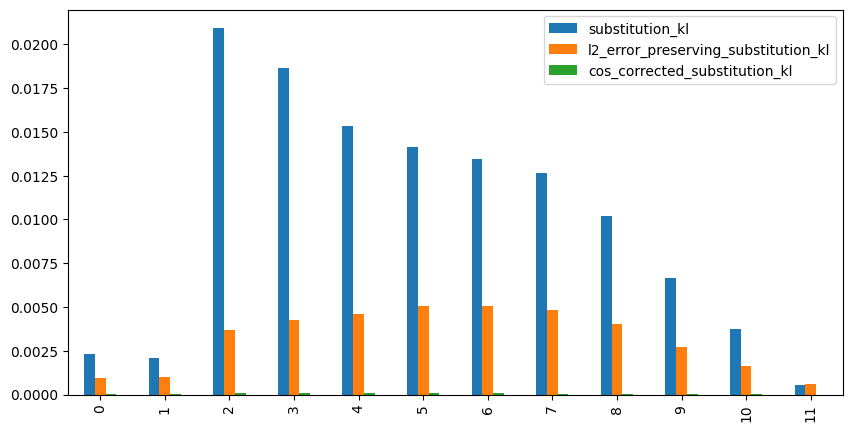

In [17]:
single_token_mean_df = pd.DataFrame({
    l: single_token_result_dfs[l].query('position == 33').mean(axis=0) for l in layers
}).T

kl_cols = ['substitution_kl', 'l2_error_preserving_substitution_kl', 'cos_corrected_substitution_kl']
single_token_mean_df[kl_cols].plot(kind='bar', figsize=(10, 5))

In [18]:
rdf = result_dfs[6]

In [19]:
rdf['kl_diff'] = rdf['substitution_kl'] - rdf['l2_error_preserving_substitution_kl']

In [20]:
corr_df = rdf.corr()

In [21]:
# imshow with no x labels
fig = px.imshow(corr_df)
fig.update_xaxes(showticklabels=False)
fig.show()
